### Importations

In [70]:
import pandas as pd
import string
import numpy as np
from pathlib import Path
import pickle 
import json
from datetime import datetime
import re
from scipy.sparse import hstack, csr_matrix
# Machine Learning & NLP
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, classification_report)
import xgboost as xgb
#Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

### Configurations initiales


In [71]:
BASE_DIR=Path(r"C:\Users\Infinix\Desktop\Projet fil rouge")
PROCESSED_DATA_DIR= BASE_DIR/"data/processed"
MODELS_DIR= BASE_DIR/"models"/"trained"
REPORTS_DIR=BASE_DIR/"reports"
FIGURES_DIR=REPORTS_DIR/"figures"
MODELS_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

### Vérification et lecture

In [72]:
RANDOM_STATE = 42
ml_data_path = PROCESSED_DATA_DIR / "medical_dataset_ml.csv"

if not ml_data_path.exists():
    print(f" ERREUR: {ml_data_path} n'existe pas!")
    exit(1)

df = pd.read_csv(ml_data_path)
print(f" Dataset chargé: {df.shape[0]} patients")

print(f"Exemple de symptômes (peuvent être des phrases):")
for i in range(min(3, len(df))):
    symptoms = df['All_Symptoms'].iloc[i]
    disease = df['Disease'].iloc[i]
    print(f"   {i+1}. Symptômes: '{symptoms[:80]}...'")
    print(f"      Maladie: {disease}\n")


 Dataset chargé: 4920 patients
Exemple de symptômes (peuvent être des phrases):
   1. Symptômes: 'itching, skin_rash, nodal_skin_eruptions, dischromic _patches, 6...'
      Maladie: Fungal infection

   2. Symptômes: 'skin_rash, nodal_skin_eruptions, dischromic _patches, 5...'
      Maladie: Fungal infection

   3. Symptômes: 'itching, nodal_skin_eruptions, dischromic _patches, 5...'
      Maladie: Fungal infection



### Word Cloud des symptomes

Text(0.5, 1.0, 'Word Cloud distribution des symptomes')

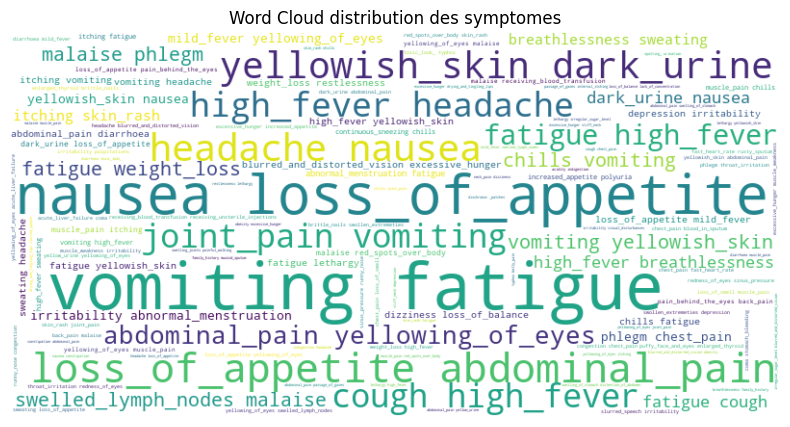

In [73]:
from wordcloud import WordCloud
all_symptoms_text = ' '.join(df['All_Symptoms'].astype(str).tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_symptoms_text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud distribution des symptomes")

### Prétraitement NLP des symptomes
1. Nettoyer le texte:(miniscules, ponctuation)+Tokenization
2. Créer des features TD-IDF
3. Combiner avec les features quantitatives

#### Tokenization

In [74]:
from nltk.tokenize import wordpunct_tokenize
cleaned_symptoms=[]
for i in range(len(df)):
    Sym=df['All_Symptoms'].iloc[i].lower()
    Sym= Sym.translate(str.maketrans('', '', string.punctuation))
    #illiminer les chiffres à la fin
    Sym=re.sub(r'\d+$','',Sym)
    cleaned_symptoms.append(Sym)
    

df['Cleaned_Symptoms']=cleaned_symptoms
df['tokens']=df['Cleaned_Symptoms'].apply(wordpunct_tokenize)

In [75]:
df.Cleaned_Symptoms.iloc[3]

'itching skinrash dischromic patches '

Traitment des stopwords

In [76]:
from nltk.corpus import stopwords
df['tokens']=df['tokens'].apply(lambda x :[w for w in x if w not in set(stopwords.words('english'))])

In [77]:
# def clean_text(text):
#     if pd.isna(text):
#         return ""
#     text = str(text).lower()
#     text = text.replace(',', ' ')
#     text = text.replace('_', ' ')
#     text= re.sub(r"\d", "", text)
#     text = ''.join(c for c in text if c.isalnum() or c.isspace())
#     text = ' '.join(text.split())
#     return text

# df['tokens'] = df['tokens'].apply(clean_text)
# print(f"Après: '{df['tokens'].iloc[0]}'")

### TF-IDF VECTORIZATION 
TF-IDF = Term Frequency - Inverse Document Frequency

In [78]:
df['Symptoms_Clean']=df['tokens'].apply(lambda x: ' '.join([word for word in x]))

In [79]:
vectorizer=TfidfVectorizer(max_features=3000)
X=vectorizer.fit_transform(df['Symptoms_Clean'])
y=df['Disease']
# label_encoder = LabelEncoder()
# y= label_encoder.fit_transform(y)

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [81]:
# X_text = df['Symptoms_Clean']
# y = df['Disease']
# quantitative_features = []
# X_quant_df = pd.DataFrame()

# if 'Symptom_Count' in df.columns:
#     X_quant_df['Symptom_Count'] = df['Symptom_Count']
#     quantitative_features.append('Symptom_Count')

# if 'Severity_Score' in df.columns:
#     X_quant_df['Severity_Score'] = df['Severity_Score']
#     quantitative_features.append('Severity_Score')

# # Encoder le target
# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(y)

In [82]:

# X_text_train, X_text_test, X_quant_train, X_quant_test, y_train, y_test = train_test_split(
#     X_text,
#     X_quant_df,
#     y_encoded,
#     test_size=0.2,
#     random_state=RANDOM_STATE,
#     stratify=y_encoded
# )
# print(f"Train: {len(X_text_train):,} patients ({len(X_text_train)/len(df)*100:.1f}%)")
# print(f"Test:  {len(X_text_test):,} patients ({len(X_text_test)/len(df)*100:.1f}%)")


In [83]:
# tfidf = TfidfVectorizer(
#     max_features=500,
#     ngram_range=(1, 2),  # Unigrammes et bigrammes
#     min_df=2,
#     max_df=0.8,
#     strip_accents='unicode'
# )
# X_tfidf_train = tfidf.fit_transform(X_text_train)
# X_tfidf_test = tfidf.transform(X_text_test)
# print(f"Features TF-IDF:")
# print(f"   • Vocabulaire appris: {len(tfidf.vocabulary_)} mots")
# print(f"   • Features par échantillon: {X_tfidf_train.shape[1]}")
# print(f"   • Train shape: {X_tfidf_train.shape}")
# print(f"   • Test shape: {X_tfidf_test.shape}")

In [84]:
# # Convertir en DataFrame
# X_tfidf_train_df = pd.DataFrame(
#     X_tfidf_train.toarray(),
#     columns=[f'tfidf_{i}' for i in range(X_tfidf_train.shape[1])],
#     index=X_text_train.index
# )
# X_tfidf_train_df = X_tfidf_train_df.reset_index(drop=True)
# X_tfidf_test_df = pd.DataFrame(
#     X_tfidf_test.toarray(),
#     columns=[f'tfidf_{i}' for i in range(X_tfidf_test.shape[1])],
#     index=X_text_test.index
# )
# X_tfidf_test_df = X_tfidf_test_df.reset_index(drop=True)

# X_quant_train = X_quant_train.reset_index(drop=True)
# X_quant_test  = X_quant_test.reset_index(drop=True)

# X_train_final = pd.concat([X_tfidf_train_df, X_quant_train.reset_index(drop=True)], axis=1)
# X_test_final = pd.concat([X_tfidf_test_df, X_quant_test.reset_index(drop=True)], axis=1)

# tfidf_path = MODELS_DIR / "tfidf_vectorizer.pkl"
# with open(tfidf_path, 'wb') as f:
#     pickle.dump(tfidf, f)
# print(f"TF-IDF sauvegardé: {tfidf_path}")

### Sauvegarder le vectorizer

### Features quantitatives

### Encodage du target

### Split train test

### Entrainement Random Forest

In [86]:
rf_model = RandomForestClassifier()

print("Entraînement en cours...")
rf_model.fit(X_train, y_train)
print("Random Forest entraîné")

# Prédictions
y_pred_rf = rf_model.predict(X_test)
print("Decision Tree Classifier:\n", classification_report(y_test, y_pred_rf))
# # Métriques
# rf_accuracy = accuracy_score(y_test, y_pred_rf)
# rf_precision = precision_score(y_test, y_pred_rf, average='weighted', zero_division=0)
# rf_recall = recall_score(y_test, y_pred_rf, average='weighted', zero_division=0)
# rf_f1 = f1_score(y_test, y_pred_rf, average='weighted', zero_division=0)

# print(f"Performance Random Forest:")
# print(f"Accuracy:  {rf_accuracy*100:.2f}%")
# print(f"Precision: {rf_precision*100:.2f}%")
# print(f"Recall:    {rf_recall*100:.2f}%")
# print(f"F1-Score:  {rf_f1*100:.2f}%")

Entraînement en cours...
Random Forest entraîné
Decision Tree Classifier:
                                          precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00        18
                                   AIDS       1.00      1.00      1.00        30
                                   Acne       1.00      1.00      1.00        24
                    Alcoholic hepatitis       1.00      1.00      1.00        25
                                Allergy       1.00      1.00      1.00        24
                              Arthritis       1.00      1.00      1.00        23
                       Bronchial Asthma       1.00      1.00      1.00        33
                   Cervical spondylosis       1.00      1.00      1.00        23
                            Chicken pox       1.00      1.00      1.00        21
                    Chronic cholestasis       1.00      1.00      1.00        15
                            Commo

### ENTRAÎNEMENT XGBOOST